# Feature Importance
For each of the 12 model runs used in the model assessment procedure we produce a feature importance plot. In this notebook I sequentially drop the least important group of features in an attempt to increase perforance. Finally I test the impact of some dummy variables on model performance.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import pickle
from timeit import default_timer as timer
from datetime import date, datetime, timezone
from dateutil.relativedelta import relativedelta
from dateutil import parser
import traceback

from dogs import modelling

In [2]:
DATA_DIR = '../data'

In [25]:
# read data
modelling_data = pd.read_csv(os.path.join(DATA_DIR, 'modelling_data_25days.csv'), index_col = 'race_id')
modelling_data

,date_time,winning_box,benchmark,min_time_1,min_time_2,min_time_3,min_time_4,min_time_5,min_time_6,avg_time_1,...,pcnt_place_3,pcnt_place_4,pcnt_place_5,pcnt_place_6,pcnt_show_1,pcnt_show_2,pcnt_show_3,pcnt_show_4,pcnt_show_5,pcnt_show_6
race_id,,,,,,,,,,,,,,,,,,,,,
2539774,2008-11-15 20:58:00+00:00,5,2,29.08,28.95,29.13,28.89,28.76,29.74,29.176667,...,0.5,0.500000,1.0,0.000000,0.666667,1.000000,0.500000,0.500000,1.0,0.000000
2539775,2008-11-15 21:14:00+00:00,2,1,29.11,29.10,29.25,29.13,29.10,29.02,29.120000,...,0.0,0.500000,0.0,0.333333,0.333333,1.000000,0.666667,0.500000,0.0,0.666667
2851623,2010-08-30 10:07:00+00:00,4,5,30.02,29.95,30.74,30.23,29.84,29.78,30.415000,...,0.0,0.000000,0.5,0.333333,0.500000,0.000000,0.000000,0.000000,0.5,1.000000
2851624,2010-08-30 10:23:00+00:00,3,4,29.99,30.11,30.11,29.53,29.71,29.71,30.117500,...,0.0,0.666667,1.0,0.666667,0.000000,0.000000,0.000000,0.666667,1.0,0.666667
2539777,2008-11-15 21:45:00+00:00,0,1,NaN,NaN,31.08,NaN,30.32,29.47,NaN,...,0.0,NaN,0.0,1.000000,NaN,NaN,0.000000,NaN,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539765,2008-11-15 18:38:00+00:00,0,5,28.85,29.00,29.13,29.10,29.50,28.87,28.865000,...,0.5,0.500000,0.0,0.333333,1.000000,0.666667,0.500000,0.750000,0.0,0.333333
2539766,2008-11-15 18:56:00+00:00,3,2,28.89,29.44,29.55,29.43,29.67,29.04,29.193333,...,0.0,0.000000,0.0,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.500000
2539767,2008-11-15 19:11:00+00:00,5,5,29.65,29.71,30.10,29.52,29.95,29.56,29.890000,...,0.5,0.500000,0.0,0.333333,0.333333,0.500000,0.750000,0.500000,0.0,0.666667


## Cross Validation with early stopping

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 48)
Test shape:  (282, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']
[1]	cv_agg's accuracy: 0.183018 + 0.000791651
[2]	cv_agg's accuracy: 0.186966 + 0.00202919
[3]	cv_agg's accuracy: 0.192118 + 0.00127939
[4]	cv_agg's accuracy: 0.194788 + 0

[30]	cv_agg's accuracy: 0.20247 + 0.00115043
[31]	cv_agg's accuracy: 0.203144 + 0.0016493
[32]	cv_agg's accuracy: 0.203518 + 0.00198415
[33]	cv_agg's accuracy: 0.202283 + 0.000961611
[34]	cv_agg's accuracy: 0.20247 + 0.00216078
[35]	cv_agg's accuracy: 0.201759 + 0.00235845
[36]	cv_agg's accuracy: 0.201647 + 0.00285587
[37]	cv_agg's accuracy: 0.200711 + 0.00299875
[38]	cv_agg's accuracy: 0.200674 + 0.00391001
[39]	cv_agg's accuracy: 0.200824 + 0.00425125
[40]	cv_agg's accuracy: 0.200412 + 0.00365256
[41]	cv_agg's accuracy: 0.199364 + 0.00415154
[42]	cv_agg's accuracy: 0.20015 + 0.00376915
[43]	cv_agg's accuracy: 0.200636 + 0.00385316
[44]	cv_agg's accuracy: 0.200824 + 0.0041909
[45]	cv_agg's accuracy: 0.201273 + 0.00451695
[46]	cv_agg's accuracy: 0.201198 + 0.00443584
[47]	cv_agg's accuracy: 0.200674 + 0.00477756
[48]	cv_agg's accuracy: 0.199439 + 0.00465313
[49]	cv_agg's accuracy: 0.199439 + 0.00417605
[50]	cv_agg's accuracy: 0.199401 + 0.00434815
[51]	cv_agg's accuracy: 0.198653 + 0.0

[22]	cv_agg's accuracy: 0.205196 + 0.00110236
[23]	cv_agg's accuracy: 0.205568 + 0.000730501
[24]	cv_agg's accuracy: 0.206051 + 0.00127454
[25]	cv_agg's accuracy: 0.207537 + 0.00160089
[26]	cv_agg's accuracy: 0.206868 + 0.00146853
[27]	cv_agg's accuracy: 0.207314 + 0.00107956
[28]	cv_agg's accuracy: 0.207835 + 0.00204107
[29]	cv_agg's accuracy: 0.207314 + 0.0022954
[30]	cv_agg's accuracy: 0.206943 + 0.00231435
[31]	cv_agg's accuracy: 0.206868 + 0.00295546
[32]	cv_agg's accuracy: 0.205902 + 0.00185708
[33]	cv_agg's accuracy: 0.206645 + 0.00126997
[34]	cv_agg's accuracy: 0.206459 + 0.0013888
[35]	cv_agg's accuracy: 0.20553 + 0.00245122
[36]	cv_agg's accuracy: 0.204341 + 0.00168545
[37]	cv_agg's accuracy: 0.20501 + 0.00210912
[38]	cv_agg's accuracy: 0.204861 + 0.00244923
[39]	cv_agg's accuracy: 0.203969 + 0.00235403
[40]	cv_agg's accuracy: 0.204118 + 0.00219087
[41]	cv_agg's accuracy: 0.204601 + 0.00224687
[42]	cv_agg's accuracy: 0.204713 + 0.00181698
[43]	cv_agg's accuracy: 0.204192 + 0.

[2]	cv_agg's accuracy: 0.187258 + 0.00236415
[3]	cv_agg's accuracy: 0.194677 + 0.00237081
[4]	cv_agg's accuracy: 0.195932 + 0.00199182
[5]	cv_agg's accuracy: 0.200177 + 0.000367068
[6]	cv_agg's accuracy: 0.200694 + 0.00159148
[7]	cv_agg's accuracy: 0.201248 + 0.00182458
[8]	cv_agg's accuracy: 0.201764 + 0.00186868
[9]	cv_agg's accuracy: 0.200399 + 0.00150293
[10]	cv_agg's accuracy: 0.200989 + 0.00180844
[11]	cv_agg's accuracy: 0.202097 + 0.00178388
[12]	cv_agg's accuracy: 0.202761 + 0.00253569
[13]	cv_agg's accuracy: 0.203352 + 0.00337793
[14]	cv_agg's accuracy: 0.204496 + 0.0011463
[15]	cv_agg's accuracy: 0.205087 + 0.000716838
[16]	cv_agg's accuracy: 0.203795 + 0.00144968
[17]	cv_agg's accuracy: 0.205197 + 0.0036295
[18]	cv_agg's accuracy: 0.203536 + 0.0039032
[19]	cv_agg's accuracy: 0.203573 + 0.004207
[20]	cv_agg's accuracy: 0.20409 + 0.00300875
[21]	cv_agg's accuracy: 0.204607 + 0.00245426
[22]	cv_agg's accuracy: 0.205345 + 0.00299464
[23]	cv_agg's accuracy: 0.206785 + 0.00180594


Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 146, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[2]	cv_agg's accuracy: 0.187083 + 0.00393919
[3]	cv_agg's accuracy: 0.187676 + 0.00360039
[4]	cv_agg's accuracy: 0.19313 + 0.00200574
[5]	cv_agg's accuracy: 0.195764 + 0.0020643
[6]	cv_agg's accuracy: 0.197693 + 0.0016989
[7]	cv_agg's accuracy: 0.197544 + 0.00140652
[8]	cv_agg's accuracy: 0.19747 + 0.0033644
[9]	cv_agg's accuracy: 0.200772 + 0.00517642
[10]	cv_agg's accuracy: 0.201699 + 0.00548798
[11]	cv_agg's accuracy: 0.201736 + 0.00534569
[12]	cv_agg's accuracy: 0.203406 + 0.00495164
[13]	cv_agg's accuracy: 0.203035 + 0.00479275
[14]	cv_agg's accuracy: 0.202886 + 0.00378279
[15]	cv_agg's accuracy: 0.203294 + 0.00378569
[16]	cv_agg's accuracy: 0.203554 + 0.00366753
[17]	cv_agg's accuracy: 0.202478 + 0.00224113
[18]	cv_agg's accuracy: 0.202256 + 0.00226055
[19]	cv_agg's accuracy: 0.203109 + 0.00119324
[20]	cv_agg's accuracy: 0.203146 + 0.00248861
[21]	cv_agg's accuracy: 0.202107 + 0.00283841
[22]	cv_agg's accuracy: 0.201885 + 0.0018175
[23]	cv_agg's accuracy: 0.202219 + 0.00308222
[2

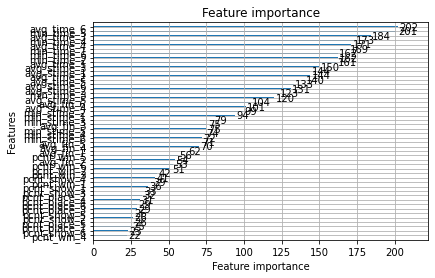

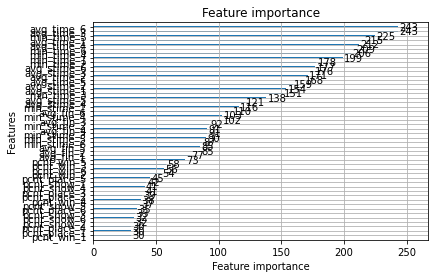

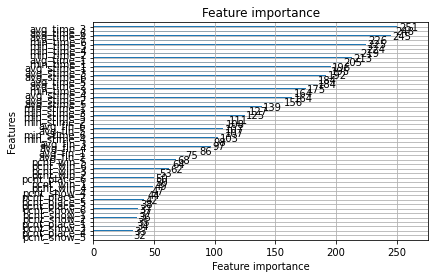

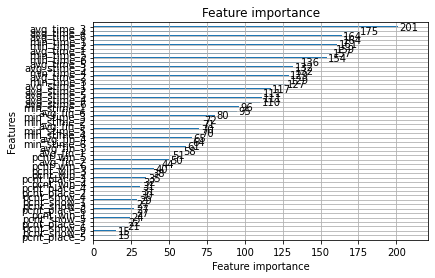

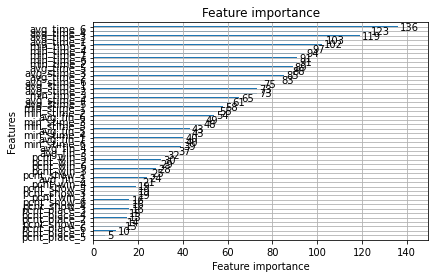

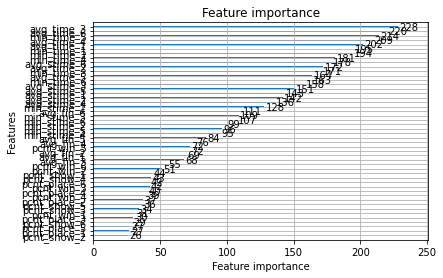

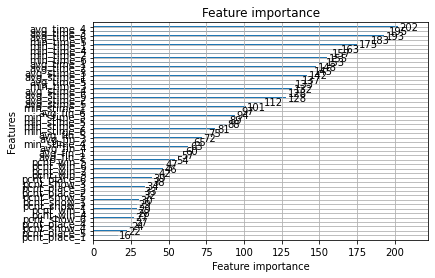

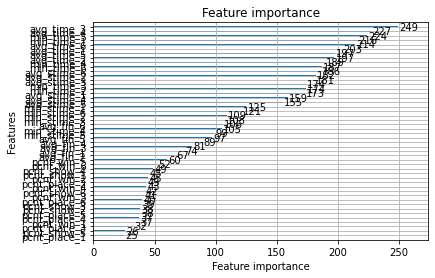

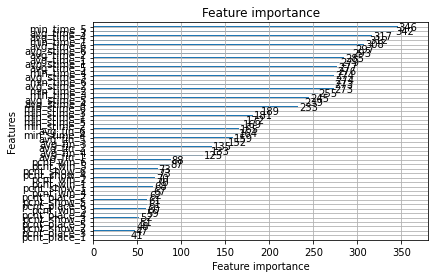

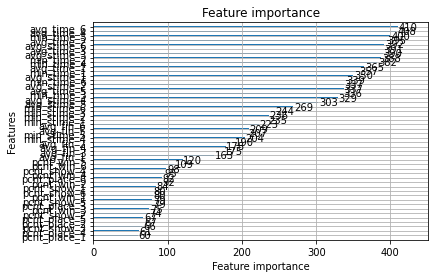

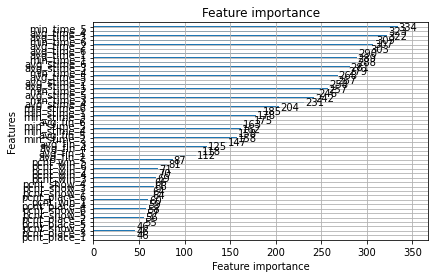

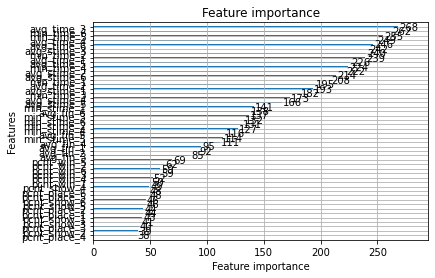

In [4]:
results = {}
results['cv'] = modelling(modelling_data, method = 'cv', nfold = 3, training_months = 150, feature_importance = True)

In [11]:
drop_cols = list(modelling_data.filter(regex = 'pcnt_place'))
drop_cols

['pcnt_place_1',
 'pcnt_place_2',
 'pcnt_place_3',
 'pcnt_place_4',
 'pcnt_place_5',
 'pcnt_place_6']

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 42)
Test shape:  (282, 42)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3' 'pcnt_show_4' 'pcnt_show_5'
 'pcnt_show_6']
[1]	cv_agg's accuracy: 0.181702 + 0.000609188
[2]	cv_agg's accuracy: 0.184785 + 0.00174839
[3]	cv_agg's accuracy: 0.189862 + 0.00429238
[4]	cv_agg's accuracy: 0.192645 + 0.00296772
[5]	cv_agg's accuracy: 0.193434 + 0.00301758
[6]	cv_agg's accuracy: 0.196856 + 0.

[2]	cv_agg's accuracy: 0.187126 + 0.00117362
[3]	cv_agg's accuracy: 0.190232 + 0.00357447
[4]	cv_agg's accuracy: 0.191542 + 0.00481021
[5]	cv_agg's accuracy: 0.19506 + 0.00372996
[6]	cv_agg's accuracy: 0.196407 + 0.000788871
[7]	cv_agg's accuracy: 0.197268 + 0.000591514
[8]	cv_agg's accuracy: 0.198653 + 0.00158701
[9]	cv_agg's accuracy: 0.199027 + 0.000426219
[10]	cv_agg's accuracy: 0.199626 + 0.00158253
[11]	cv_agg's accuracy: 0.199289 + 0.000864956
[12]	cv_agg's accuracy: 0.201198 + 0.00189294
[13]	cv_agg's accuracy: 0.200674 + 0.0019685
[14]	cv_agg's accuracy: 0.20146 + 0.00091069
[15]	cv_agg's accuracy: 0.200299 + 0.000575507
[16]	cv_agg's accuracy: 0.202208 + 0.000973698
[17]	cv_agg's accuracy: 0.202994 + 0.00118064
[18]	cv_agg's accuracy: 0.202283 + 0.00148732
[19]	cv_agg's accuracy: 0.203181 + 0.00115543
[20]	cv_agg's accuracy: 0.20277 + 0.00199391
[21]	cv_agg's accuracy: 0.202957 + 0.00275534
[22]	cv_agg's accuracy: 0.204529 + 0.00230342
[23]	cv_agg's accuracy: 0.204079 + 0.002

[41]	cv_agg's accuracy: 0.204417 + 0.00535311
[42]	cv_agg's accuracy: 0.203894 + 0.00626345
[43]	cv_agg's accuracy: 0.203409 + 0.0059429
[44]	cv_agg's accuracy: 0.204603 + 0.006374
[45]	cv_agg's accuracy: 0.204193 + 0.00612008
[46]	cv_agg's accuracy: 0.203521 + 0.00708606
[47]	cv_agg's accuracy: 0.20326 + 0.00686585
[48]	cv_agg's accuracy: 0.204155 + 0.0074999
[49]	cv_agg's accuracy: 0.204006 + 0.00767902
29
The maxium accuracy on the validation set was 0.20632
The ideal number of iterations was 29.
AxesSubplot(0.125,0.125;0.775x0.755)
Model correct: 0.190 Benchmark correct 0.270
Building model for 2018:6
Train shape:  (26906, 42)
Test shape:  (272, 42)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_

[20]	cv_agg's accuracy: 0.200015 + 0.00294891
[21]	cv_agg's accuracy: 0.20057 + 0.00216439
[22]	cv_agg's accuracy: 0.200311 + 0.00265863
[23]	cv_agg's accuracy: 0.201198 + 0.00379086
[24]	cv_agg's accuracy: 0.202604 + 0.00469642
[25]	cv_agg's accuracy: 0.202493 + 0.00436439
[26]	cv_agg's accuracy: 0.202641 + 0.00632892
[27]	cv_agg's accuracy: 0.203121 + 0.00559384
[28]	cv_agg's accuracy: 0.203454 + 0.0045646
[29]	cv_agg's accuracy: 0.203787 + 0.00475343
[30]	cv_agg's accuracy: 0.204823 + 0.00363944
[31]	cv_agg's accuracy: 0.204009 + 0.00377386
[32]	cv_agg's accuracy: 0.204638 + 0.00479522
[33]	cv_agg's accuracy: 0.204712 + 0.0059402
[34]	cv_agg's accuracy: 0.205304 + 0.00539471
[35]	cv_agg's accuracy: 0.205045 + 0.00486598
[36]	cv_agg's accuracy: 0.204823 + 0.00479856
[37]	cv_agg's accuracy: 0.203861 + 0.00535809
[38]	cv_agg's accuracy: 0.203528 + 0.00464216
[39]	cv_agg's accuracy: 0.20338 + 0.00474146
[40]	cv_agg's accuracy: 0.203676 + 0.00358358
[41]	cv_agg's accuracy: 0.203676 + 0.0

AxesSubplot(0.125,0.125;0.775x0.755)
perform_modelling encountered an error for 2018: 10
Building model for 2018:11
Train shape:  (26956, 42)
Test shape:  (208, 42)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3' 'pcnt_show_4' 'pcnt_show_5'
 'pcnt_show_6']
[1]	cv_agg's accuracy: 0.182223 + 0.00320514


Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 146, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[2]	cv_agg's accuracy: 0.184783 + 0.00213603
[3]	cv_agg's accuracy: 0.188715 + 0.00408244
[4]	cv_agg's accuracy: 0.192685 + 0.00431766
[5]	cv_agg's accuracy: 0.197359 + 0.00424766
[6]	cv_agg's accuracy: 0.198694 + 0.00380521
[7]	cv_agg's accuracy: 0.19799 + 0.00528098
[8]	cv_agg's accuracy: 0.199325 + 0.00474123
[9]	cv_agg's accuracy: 0.201143 + 0.00644575
[10]	cv_agg's accuracy: 0.201588 + 0.00416668
[11]	cv_agg's accuracy: 0.201365 + 0.00338108
[12]	cv_agg's accuracy: 0.20259 + 0.00401566
[13]	cv_agg's accuracy: 0.203925 + 0.00402886
[14]	cv_agg's accuracy: 0.204407 + 0.00512432
[15]	cv_agg's accuracy: 0.203814 + 0.0056557
[16]	cv_agg's accuracy: 0.203962 + 0.00451842
[17]	cv_agg's accuracy: 0.204444 + 0.00460115
[18]	cv_agg's accuracy: 0.201996 + 0.00468693
[19]	cv_agg's accuracy: 0.203665 + 0.00516699
[20]	cv_agg's accuracy: 0.205075 + 0.00504872
[21]	cv_agg's accuracy: 0.206336 + 0.0055079
[22]	cv_agg's accuracy: 0.205817 + 0.0048333
[23]	cv_agg's accuracy: 0.206188 + 0.0051537
[2

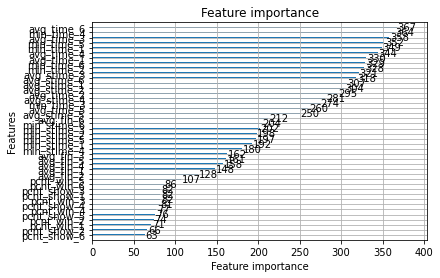

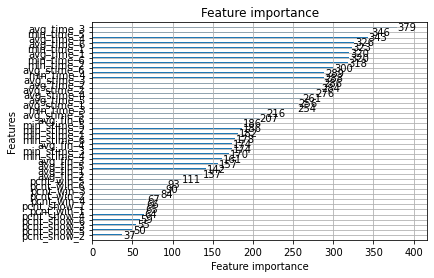

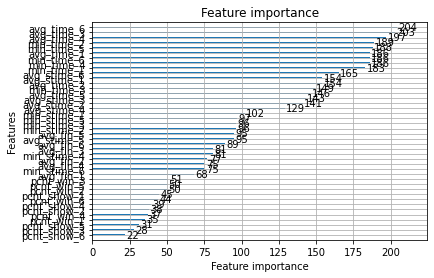

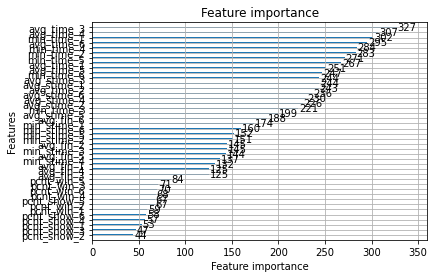

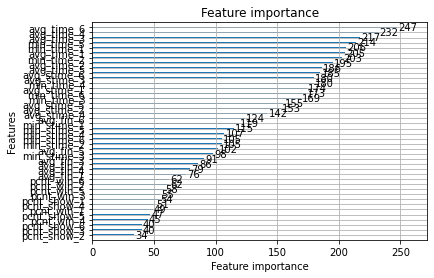

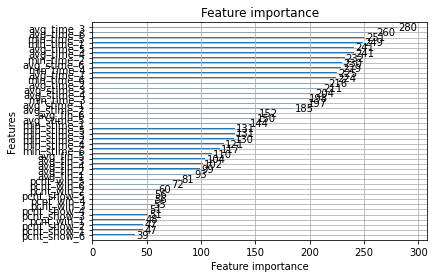

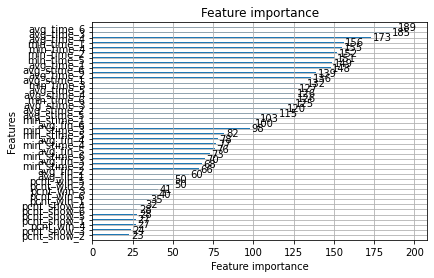

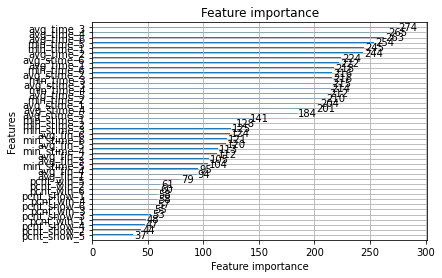

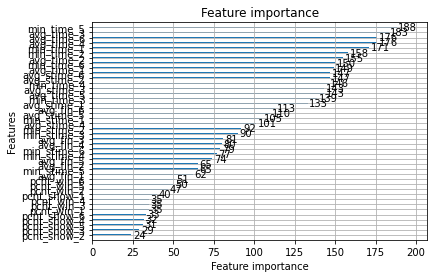

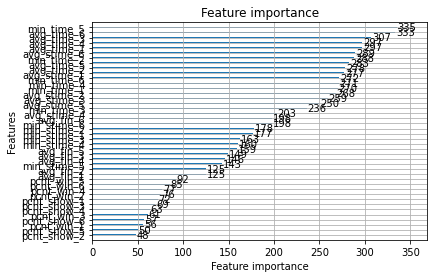

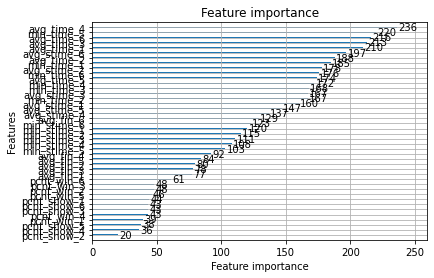

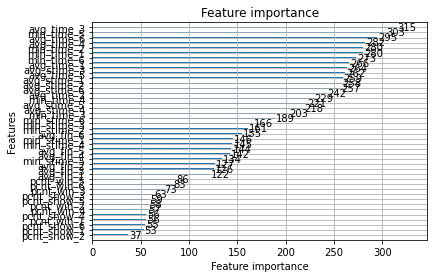

In [13]:
results['pcnt_place'] = modelling(modelling_data.drop(drop_cols, axis = 1),
                                  method = 'cv', nfold = 3, training_months = 150, feature_importance = True)

pcnt show is consistently the worst feature so we'll drop that too

In [14]:
drop_cols = list(modelling_data.filter(regex = 'pcnt_place|pcnt_show'))
drop_cols

['pcnt_place_1',
 'pcnt_place_2',
 'pcnt_place_3',
 'pcnt_place_4',
 'pcnt_place_5',
 'pcnt_place_6',
 'pcnt_show_1',
 'pcnt_show_2',
 'pcnt_show_3',
 'pcnt_show_4',
 'pcnt_show_5',
 'pcnt_show_6']

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 36)
Test shape:  (282, 36)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6']
[1]	cv_agg's accuracy: 0.183958 + 0.00170628
[2]	cv_agg's accuracy: 0.18659 + 0.00297935
[3]	cv_agg's accuracy: 0.190877 + 0.00499573
[4]	cv_agg's accuracy: 0.194073 + 0.00600614
[5]	cv_agg's accuracy: 0.195051 + 0.00514773
[6]	cv_agg's accuracy: 0.196969 + 0.00591025
[7]	cv_agg's accuracy: 0.198849 + 0.0029135
[8]	cv_agg's accuracy: 0.198849 + 0

[26]	cv_agg's accuracy: 0.203219 + 0.00265598
[27]	cv_agg's accuracy: 0.20393 + 0.00330828
[28]	cv_agg's accuracy: 0.204042 + 0.00388996
[29]	cv_agg's accuracy: 0.204529 + 0.00363311
[30]	cv_agg's accuracy: 0.203705 + 0.00338057
[31]	cv_agg's accuracy: 0.202657 + 0.00406016
[32]	cv_agg's accuracy: 0.201497 + 0.00416584
[33]	cv_agg's accuracy: 0.20262 + 0.00463877
[34]	cv_agg's accuracy: 0.202582 + 0.00433947
[35]	cv_agg's accuracy: 0.202021 + 0.00344937
[36]	cv_agg's accuracy: 0.20277 + 0.00340125
[37]	cv_agg's accuracy: 0.203219 + 0.00354641
[38]	cv_agg's accuracy: 0.202545 + 0.00416133
[39]	cv_agg's accuracy: 0.202957 + 0.00349379
[40]	cv_agg's accuracy: 0.202246 + 0.00304652
[41]	cv_agg's accuracy: 0.202882 + 0.00243606
[42]	cv_agg's accuracy: 0.203256 + 0.00290333
[43]	cv_agg's accuracy: 0.202919 + 0.00238054
[44]	cv_agg's accuracy: 0.202283 + 0.00269842
[45]	cv_agg's accuracy: 0.202096 + 0.00196711
[46]	cv_agg's accuracy: 0.202208 + 0.00224633
[47]	cv_agg's accuracy: 0.202732 + 0.

[2]	cv_agg's accuracy: 0.192745 + 0.00106041
[3]	cv_agg's accuracy: 0.194641 + 0.00139033
[4]	cv_agg's accuracy: 0.197168 + 0.00213361
[5]	cv_agg's accuracy: 0.197094 + 0.000415399
[6]	cv_agg's accuracy: 0.196648 + 0.00269256
[7]	cv_agg's accuracy: 0.197949 + 0.00286341
[8]	cv_agg's accuracy: 0.199472 + 0.00196782
[9]	cv_agg's accuracy: 0.201182 + 0.00213068
[10]	cv_agg's accuracy: 0.201256 + 0.00160458
[11]	cv_agg's accuracy: 0.201479 + 0.00100145
[12]	cv_agg's accuracy: 0.202557 + 0.00193403
[13]	cv_agg's accuracy: 0.203189 + 0.00329764
[14]	cv_agg's accuracy: 0.204044 + 0.00201878
[15]	cv_agg's accuracy: 0.204304 + 0.00211317
[16]	cv_agg's accuracy: 0.204155 + 0.00135165
[17]	cv_agg's accuracy: 0.203263 + 0.00146627
[18]	cv_agg's accuracy: 0.204192 + 0.0025158
[19]	cv_agg's accuracy: 0.203561 + 0.00187205
[20]	cv_agg's accuracy: 0.203969 + 0.00229596
[21]	cv_agg's accuracy: 0.204192 + 0.00140083
[22]	cv_agg's accuracy: 0.203263 + 0.000636133
[23]	cv_agg's accuracy: 0.203709 + 0.0004

[2]	cv_agg's accuracy: 0.187331 + 0.0022856
[3]	cv_agg's accuracy: 0.192093 + 0.00334729
[4]	cv_agg's accuracy: 0.194382 + 0.00388115
[5]	cv_agg's accuracy: 0.197298 + 0.00436172
[6]	cv_agg's accuracy: 0.199254 + 0.00284372
[7]	cv_agg's accuracy: 0.199992 + 0.00238188
[8]	cv_agg's accuracy: 0.200805 + 0.00210342
[9]	cv_agg's accuracy: 0.202207 + 0.00239576
[10]	cv_agg's accuracy: 0.203979 + 0.00173374
[11]	cv_agg's accuracy: 0.204422 + 0.00303904
[12]	cv_agg's accuracy: 0.204127 + 0.0025428
[13]	cv_agg's accuracy: 0.206305 + 0.0030305
[14]	cv_agg's accuracy: 0.203979 + 0.0026738
[15]	cv_agg's accuracy: 0.205234 + 0.00364392
[16]	cv_agg's accuracy: 0.205714 + 0.00250442
[17]	cv_agg's accuracy: 0.205714 + 0.00301624
[18]	cv_agg's accuracy: 0.205936 + 0.00389871
[19]	cv_agg's accuracy: 0.205899 + 0.0038778
[20]	cv_agg's accuracy: 0.206416 + 0.00481288
[21]	cv_agg's accuracy: 0.205973 + 0.00365309
[22]	cv_agg's accuracy: 0.205382 + 0.0037651
[23]	cv_agg's accuracy: 0.205271 + 0.00409861
[2

Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 146, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[2]	cv_agg's accuracy: 0.184486 + 0.000937721
[3]	cv_agg's accuracy: 0.188641 + 0.00284693
[4]	cv_agg's accuracy: 0.191534 + 0.00119131
[5]	cv_agg's accuracy: 0.195467 + 0.00219154
[6]	cv_agg's accuracy: 0.196802 + 0.00214445
[7]	cv_agg's accuracy: 0.195393 + 0.00255778
[8]	cv_agg's accuracy: 0.199696 + 0.0011821
[9]	cv_agg's accuracy: 0.200586 + 0.00163979
[10]	cv_agg's accuracy: 0.20003 + 0.00114735
[11]	cv_agg's accuracy: 0.200141 + 0.00196671
[12]	cv_agg's accuracy: 0.200327 + 0.00225684
[13]	cv_agg's accuracy: 0.201328 + 0.0018628
[14]	cv_agg's accuracy: 0.202998 + 0.00327541
[15]	cv_agg's accuracy: 0.203146 + 0.00351993
[16]	cv_agg's accuracy: 0.203777 + 0.00404863
[17]	cv_agg's accuracy: 0.204593 + 0.00406598
[18]	cv_agg's accuracy: 0.205261 + 0.0019915
[19]	cv_agg's accuracy: 0.204407 + 0.00245107
[20]	cv_agg's accuracy: 0.204964 + 0.001535
[21]	cv_agg's accuracy: 0.204259 + 0.00127045
[22]	cv_agg's accuracy: 0.203554 + 0.00156144
[23]	cv_agg's accuracy: 0.204852 + 0.00139818
[

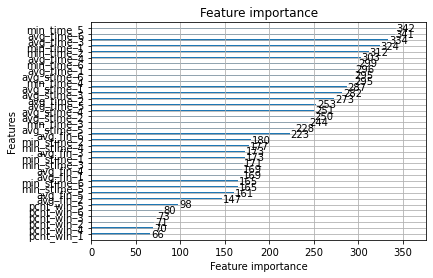

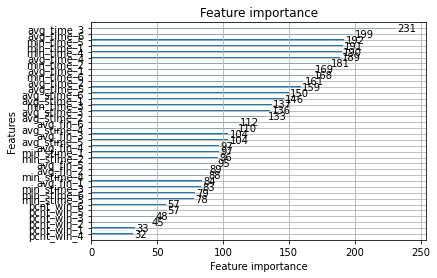

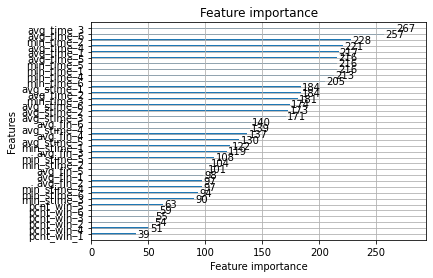

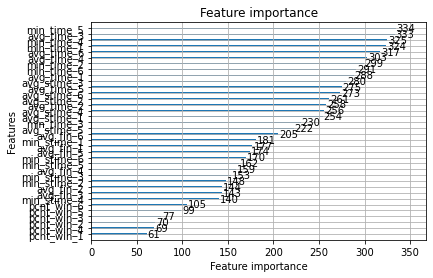

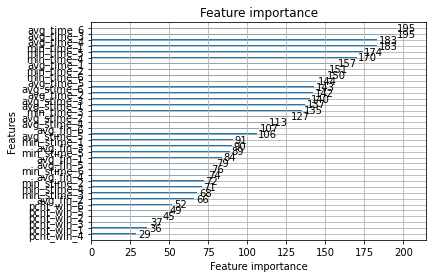

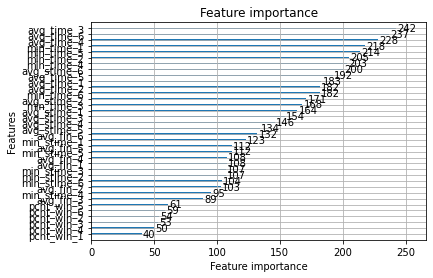

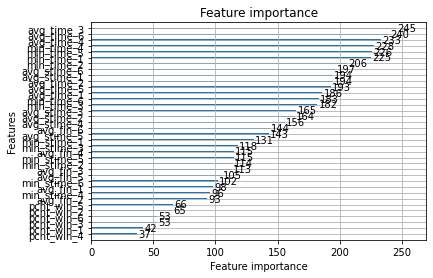

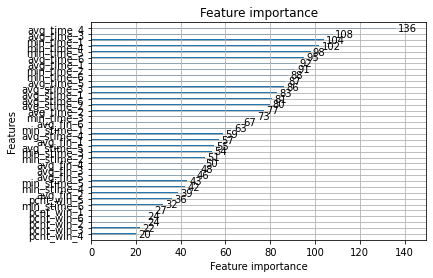

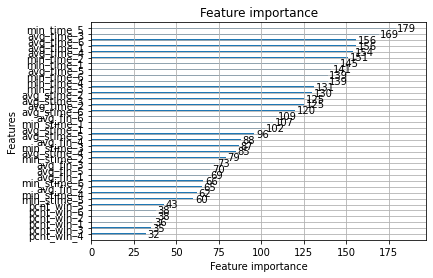

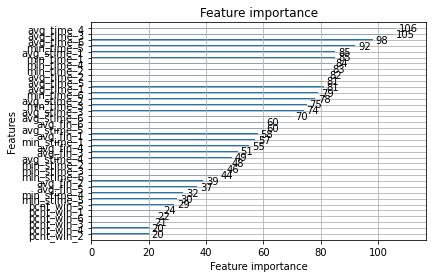

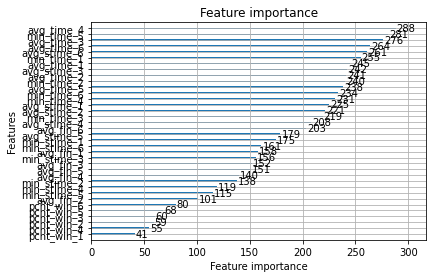

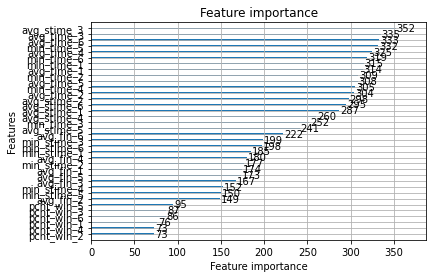

In [15]:
results['pcnt_show'] = modelling(modelling_data.drop(drop_cols, axis = 1),
                                 method = 'cv', nfold = 3, training_months = 150, feature_importance = True)

percent win is last so we'll drop that too

In [17]:
drop_cols = list(modelling_data.filter(regex = 'pcnt_place|pcnt_show|pcnt_win'))
drop_cols

['pcnt_win_1',
 'pcnt_win_2',
 'pcnt_win_3',
 'pcnt_win_4',
 'pcnt_win_5',
 'pcnt_win_6',
 'pcnt_place_1',
 'pcnt_place_2',
 'pcnt_place_3',
 'pcnt_place_4',
 'pcnt_place_5',
 'pcnt_place_6',
 'pcnt_show_1',
 'pcnt_show_2',
 'pcnt_show_3',
 'pcnt_show_4',
 'pcnt_show_5',
 'pcnt_show_6']

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 30)
Test shape:  (282, 30)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6']
[1]	cv_agg's accuracy: 0.182868 + 0.00248332
[2]	cv_agg's accuracy: 0.186703 + 0.00286517
[3]	cv_agg's accuracy: 0.188132 + 0.00377013
[4]	cv_agg's accuracy: 0.192945 + 0.00257313
[5]	cv_agg's accuracy: 0.194863 + 0.00484836
[6]	cv_agg's accuracy: 0.196668 + 0.00307276
[7]	cv_agg's accuracy: 0.196067 + 0.00216739
[8]	cv_agg's accuracy: 0.196405 + 0.00224014
[9]	cv_agg's accuracy: 0.198661 + 0.0014646
[10]	cv_agg's accuracy:

[8]	cv_agg's accuracy: 0.200508 + 0.00293237
[9]	cv_agg's accuracy: 0.202714 + 0.00277302
[10]	cv_agg's accuracy: 0.201704 + 0.00267103
[11]	cv_agg's accuracy: 0.202826 + 0.00119884
[12]	cv_agg's accuracy: 0.20234 + 0.00303488
[13]	cv_agg's accuracy: 0.202639 + 0.00241554
[14]	cv_agg's accuracy: 0.201966 + 0.00312057
[15]	cv_agg's accuracy: 0.201779 + 0.00168936
[16]	cv_agg's accuracy: 0.201779 + 0.002556
[17]	cv_agg's accuracy: 0.20219 + 0.00440585
[18]	cv_agg's accuracy: 0.201032 + 0.00216039
[19]	cv_agg's accuracy: 0.201817 + 0.00233285
[20]	cv_agg's accuracy: 0.201144 + 0.00290004
[21]	cv_agg's accuracy: 0.200807 + 0.00286396
[22]	cv_agg's accuracy: 0.201742 + 0.00222191
[23]	cv_agg's accuracy: 0.201705 + 0.00119415
[24]	cv_agg's accuracy: 0.201854 + 0.00300028
[25]	cv_agg's accuracy: 0.201331 + 0.00222678
[26]	cv_agg's accuracy: 0.200359 + 0.00259292
[27]	cv_agg's accuracy: 0.200845 + 0.00238075
[28]	cv_agg's accuracy: 0.200845 + 0.00320561
[29]	cv_agg's accuracy: 0.199798 + 0.001

[33]	cv_agg's accuracy: 0.202459 + 0.00224308
[34]	cv_agg's accuracy: 0.202274 + 0.00168971
[35]	cv_agg's accuracy: 0.201904 + 0.00206507
[36]	cv_agg's accuracy: 0.202534 + 0.0016845
[37]	cv_agg's accuracy: 0.202089 + 0.00207474
[38]	cv_agg's accuracy: 0.2022 + 0.00259794
[39]	cv_agg's accuracy: 0.202978 + 0.00283435
[40]	cv_agg's accuracy: 0.202311 + 0.00309263
[41]	cv_agg's accuracy: 0.203682 + 0.00351023
[42]	cv_agg's accuracy: 0.202904 + 0.00274963
[43]	cv_agg's accuracy: 0.203089 + 0.00257507
[44]	cv_agg's accuracy: 0.203274 + 0.00273284
[45]	cv_agg's accuracy: 0.203311 + 0.00246531
[46]	cv_agg's accuracy: 0.203645 + 0.00170496
[47]	cv_agg's accuracy: 0.203682 + 0.00181337
[48]	cv_agg's accuracy: 0.203089 + 0.00220219
[49]	cv_agg's accuracy: 0.203645 + 0.00209728
[50]	cv_agg's accuracy: 0.203163 + 0.00196792
[51]	cv_agg's accuracy: 0.203793 + 0.00208179
[52]	cv_agg's accuracy: 0.204311 + 0.00217136
[53]	cv_agg's accuracy: 0.204941 + 0.00267262
[54]	cv_agg's accuracy: 0.204163 + 0.

[13]	cv_agg's accuracy: 0.198017 + 0.0051269
[14]	cv_agg's accuracy: 0.19927 + 0.00473922
[15]	cv_agg's accuracy: 0.198091 + 0.00511784
[16]	cv_agg's accuracy: 0.198422 + 0.00620847
[17]	cv_agg's accuracy: 0.197722 + 0.00514599
[18]	cv_agg's accuracy: 0.197648 + 0.00590496
[19]	cv_agg's accuracy: 0.197574 + 0.00646831
[20]	cv_agg's accuracy: 0.19868 + 0.0061406
[21]	cv_agg's accuracy: 0.19868 + 0.00635107
[22]	cv_agg's accuracy: 0.198349 + 0.00527357
[23]	cv_agg's accuracy: 0.198091 + 0.00569937
[24]	cv_agg's accuracy: 0.198754 + 0.00543353
[25]	cv_agg's accuracy: 0.198607 + 0.0058246
[26]	cv_agg's accuracy: 0.198385 + 0.00444347
[27]	cv_agg's accuracy: 0.198017 + 0.00410928
[28]	cv_agg's accuracy: 0.198533 + 0.0037912
[29]	cv_agg's accuracy: 0.198791 + 0.00394902
[30]	cv_agg's accuracy: 0.199196 + 0.00338076
[31]	cv_agg's accuracy: 0.199418 + 0.00379124
[32]	cv_agg's accuracy: 0.199455 + 0.00424331
[33]	cv_agg's accuracy: 0.19927 + 0.00359569
[34]	cv_agg's accuracy: 0.200155 + 0.00366

Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 146, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[3]	cv_agg's accuracy: 0.190125 + 0.000749966
[4]	cv_agg's accuracy: 0.193575 + 0.00147412
[5]	cv_agg's accuracy: 0.19517 + 0.00109228
[6]	cv_agg's accuracy: 0.194873 + 0.00015254
[7]	cv_agg's accuracy: 0.19747 + 0.00262626
[8]	cv_agg's accuracy: 0.198249 + 0.00247734
[9]	cv_agg's accuracy: 0.199585 + 0.00223484
[10]	cv_agg's accuracy: 0.20092 + 0.00199965
[11]	cv_agg's accuracy: 0.200883 + 0.00268163
[12]	cv_agg's accuracy: 0.199844 + 0.00204471
[13]	cv_agg's accuracy: 0.199102 + 0.00340492
[14]	cv_agg's accuracy: 0.198991 + 0.00278846
[15]	cv_agg's accuracy: 0.198843 + 0.00192095
[16]	cv_agg's accuracy: 0.199028 + 0.00157495
[17]	cv_agg's accuracy: 0.199733 + 0.00248707
[18]	cv_agg's accuracy: 0.199399 + 0.00295505
[19]	cv_agg's accuracy: 0.200364 + 0.00338164
[20]	cv_agg's accuracy: 0.199696 + 0.00299632
[21]	cv_agg's accuracy: 0.199436 + 0.00223372
[22]	cv_agg's accuracy: 0.199659 + 0.00245249
[23]	cv_agg's accuracy: 0.201217 + 0.0031141
[24]	cv_agg's accuracy: 0.199807 + 0.0022633

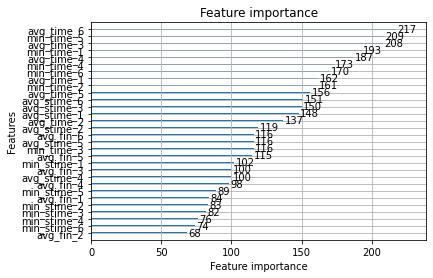

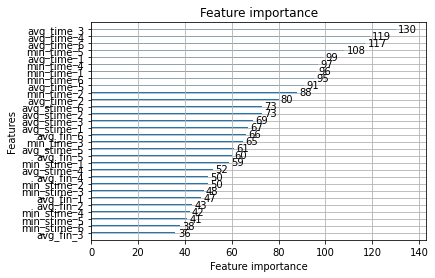

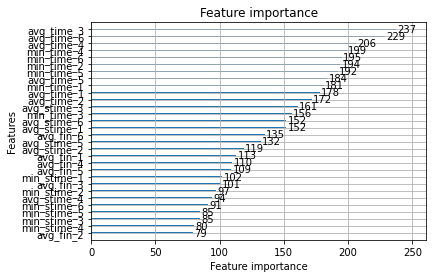

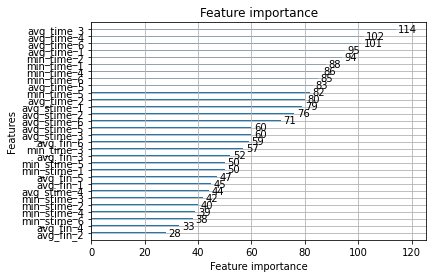

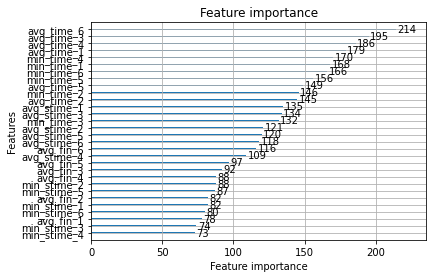

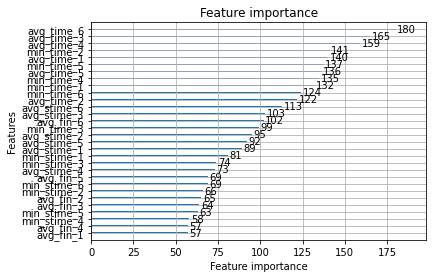

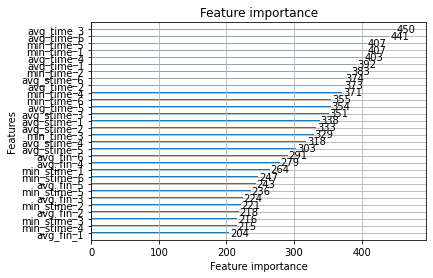

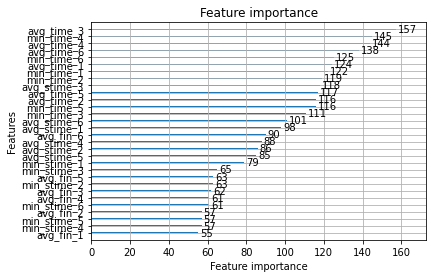

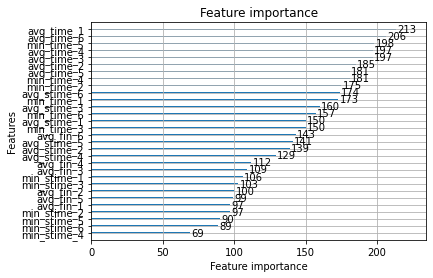

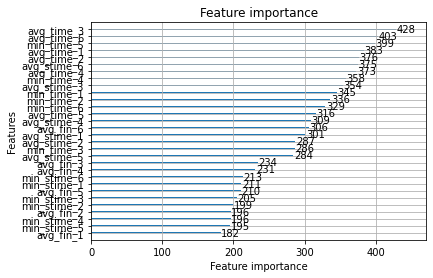

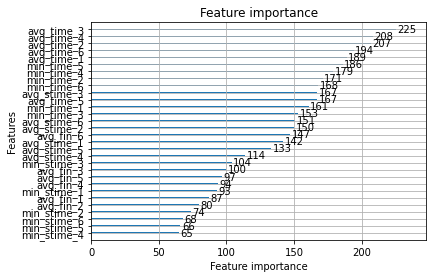

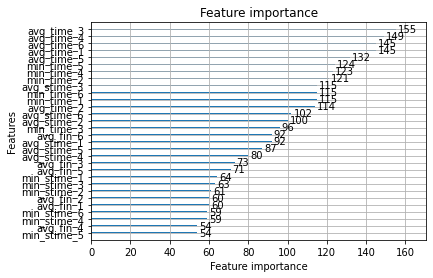

In [18]:
results['pcnt_win'] = modelling(modelling_data.drop(drop_cols, axis = 1),
                                 method = 'cv', nfold = 3, training_months = 150, feature_importance = True)

## Impact of dropping features

In [19]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Model Accuracy', 'Benchmark', 'Races', 'Features', 'Training Time'])
results_df.drop('Features', axis = 1)

,Model Accuracy,Benchmark,Races,Training Time
cv,0.195242,0.274169,2648,45.347853
pcnt_place,0.195997,0.274169,2648,40.382834
pcnt_show,0.188066,0.274169,2648,35.404984
pcnt_win,0.173716,0.274169,2648,30.567947


It looks like that dropping pcnt_place has a positive impact on the model but we should keep pnct_show and pcnt_win in the model.

# Dummy Variables
What about creating some new features based on average time, since it is the most important feature. Lets create an indicator function that tells us which dog has the fastest time

In [20]:
modelling_data.filter(regex = 'avg_time')

,avg_time_1,avg_time_2,avg_time_3,avg_time_4,avg_time_5,avg_time_6
race_id,,,,,,
2539774,29.176667,29.006667,29.365000,29.145000,28.980,29.740000
2539775,29.120000,29.265000,29.300000,29.280000,29.200,29.223333
2851623,30.415000,29.950000,30.740000,30.230000,29.995,29.983333
2851624,30.117500,30.375000,30.110000,29.933333,29.710,29.846667
2539777,NaN,NaN,31.080000,NaN,30.575,29.470000
...,...,...,...,...,...,...
2539765,28.865000,29.093333,29.185000,29.292500,29.500,29.136667
2539766,29.193333,29.505000,29.620000,29.430000,29.670,29.410000
2539767,29.890000,29.770000,30.155000,29.807500,29.960,29.660000


In [26]:
modelling_data['fastest_avg_time'] = modelling_data.filter(regex = 'avg_time').idxmin(axis = 1)
modelling_data['fastest_avg_stime'] = modelling_data.filter(regex = 'avg_stime').idxmin(axis = 1)
modelling_data['fastest_min_time'] = modelling_data.filter(regex = 'min_time').idxmin(axis = 1)
modelling_data['fastest_min_stime'] = modelling_data.filter(regex = 'min_stime').idxmin(axis = 1)
modelling_data

,date_time,winning_box,benchmark,min_time_1,min_time_2,min_time_3,min_time_4,min_time_5,min_time_6,avg_time_1,...,pcnt_show_1,pcnt_show_2,pcnt_show_3,pcnt_show_4,pcnt_show_5,pcnt_show_6,fastest_avg_time,fastest_avg_stime,fastest_min_time,fastest_min_stime
race_id,,,,,,,,,,,,,,,,,,,,,
2539774,2008-11-15 20:58:00+00:00,5,2,29.08,28.95,29.13,28.89,28.76,29.74,29.176667,...,0.666667,1.000000,0.500000,0.500000,1.0,0.000000,avg_time_5,avg_stime_3,min_time_5,min_stime_1
2539775,2008-11-15 21:14:00+00:00,2,1,29.11,29.10,29.25,29.13,29.10,29.02,29.120000,...,0.333333,1.000000,0.666667,0.500000,0.0,0.666667,avg_time_1,avg_stime_6,min_time_6,min_stime_6
2851623,2010-08-30 10:07:00+00:00,4,5,30.02,29.95,30.74,30.23,29.84,29.78,30.415000,...,0.500000,0.000000,0.000000,0.000000,0.5,1.000000,avg_time_2,avg_stime_6,min_time_6,min_stime_6
2851624,2010-08-30 10:23:00+00:00,3,4,29.99,30.11,30.11,29.53,29.71,29.71,30.117500,...,0.000000,0.000000,0.000000,0.666667,1.0,0.666667,avg_time_5,avg_stime_6,min_time_4,min_stime_4
2539777,2008-11-15 21:45:00+00:00,0,1,NaN,NaN,31.08,NaN,30.32,29.47,NaN,...,NaN,NaN,0.000000,NaN,0.0,1.000000,avg_time_6,avg_stime_6,min_time_6,min_stime_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539765,2008-11-15 18:38:00+00:00,0,5,28.85,29.00,29.13,29.10,29.50,28.87,28.865000,...,1.000000,0.666667,0.500000,0.750000,0.0,0.333333,avg_time_1,avg_stime_4,min_time_1,min_stime_4
2539766,2008-11-15 18:56:00+00:00,3,2,28.89,29.44,29.55,29.43,29.67,29.04,29.193333,...,1.000000,0.000000,0.000000,0.000000,0.0,0.500000,avg_time_1,avg_stime_6,min_time_1,min_stime_6
2539767,2008-11-15 19:11:00+00:00,5,5,29.65,29.71,30.10,29.52,29.95,29.56,29.890000,...,0.333333,0.500000,0.750000,0.500000,0.0,0.666667,avg_time_6,avg_stime_5,min_time_4,min_stime_5


In [38]:
modelling_data = pd.get_dummies(modelling_data, columns = ['fastest_avg_time', 'fastest_avg_stime', 'fastest_min_time', 'fastest_min_stime'])

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 66)
Test shape:  (282, 66)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3' 'pcnt_show_4' 'pcnt_show_5'
 'pcnt_show_6' 'fastest_avg_time_avg_time_1' 'fastest_avg_time_avg_time_2'
 'fastest_avg_time_avg_time_3' 'fastest_avg_time_avg_time_4'
 'fastest_avg_time_avg_time_5' 'fastest_avg_time_avg_time_6'
 'fastest_avg_stime_avg_stime_1' 'fastest_avg_stime_avg_stime_2'
 'fastest_avg_st

[2]	cv_agg's accuracy: 0.189222 + 0.00336921
[3]	cv_agg's accuracy: 0.19274 + 0.00164584
[4]	cv_agg's accuracy: 0.19521 + 0.00229212
[5]	cv_agg's accuracy: 0.200075 + 0.00266444
[6]	cv_agg's accuracy: 0.201347 + 0.00132552
[7]	cv_agg's accuracy: 0.203742 + 0.00162226
[8]	cv_agg's accuracy: 0.204379 + 0.000571403
[9]	cv_agg's accuracy: 0.204528 + 0.00122841
[10]	cv_agg's accuracy: 0.205277 + 0.00187923
[11]	cv_agg's accuracy: 0.206849 + 0.000870995
[12]	cv_agg's accuracy: 0.206587 + 0.00136565
[13]	cv_agg's accuracy: 0.207223 + 0.00193313
[14]	cv_agg's accuracy: 0.207036 + 0.00273093
[15]	cv_agg's accuracy: 0.207111 + 0.00148038
[16]	cv_agg's accuracy: 0.208421 + 0.00203132
[17]	cv_agg's accuracy: 0.208047 + 0.00470673
[18]	cv_agg's accuracy: 0.208383 + 0.00384481
[19]	cv_agg's accuracy: 0.208084 + 0.00408208
[20]	cv_agg's accuracy: 0.208383 + 0.00359238
[21]	cv_agg's accuracy: 0.209094 + 0.0032825
[22]	cv_agg's accuracy: 0.20988 + 0.00309184
[23]	cv_agg's accuracy: 0.209057 + 0.0031155

[14]	cv_agg's accuracy: 0.205685 + 0.00443788
[15]	cv_agg's accuracy: 0.204827 + 0.00484298
[16]	cv_agg's accuracy: 0.205237 + 0.00491966
[17]	cv_agg's accuracy: 0.205909 + 0.00479766
[18]	cv_agg's accuracy: 0.207513 + 0.00402899
[19]	cv_agg's accuracy: 0.207923 + 0.00434664
[20]	cv_agg's accuracy: 0.207401 + 0.00302264
[21]	cv_agg's accuracy: 0.205946 + 0.00255568
[22]	cv_agg's accuracy: 0.205424 + 0.00114245
[23]	cv_agg's accuracy: 0.2052 + 0.00264873
[24]	cv_agg's accuracy: 0.205797 + 0.00196608
[25]	cv_agg's accuracy: 0.207214 + 0.00154613
[26]	cv_agg's accuracy: 0.207886 + 0.00253436
[27]	cv_agg's accuracy: 0.207513 + 0.00288412
[28]	cv_agg's accuracy: 0.207886 + 0.00295278
[29]	cv_agg's accuracy: 0.207625 + 0.00272639
[30]	cv_agg's accuracy: 0.207102 + 0.00346289
[31]	cv_agg's accuracy: 0.207513 + 0.00251618
[32]	cv_agg's accuracy: 0.207252 + 0.00274571
[33]	cv_agg's accuracy: 0.206916 + 0.00305378
[34]	cv_agg's accuracy: 0.207289 + 0.00146575
[35]	cv_agg's accuracy: 0.208035 + 0

[13]	cv_agg's accuracy: 0.203459 + 0.0018313
[14]	cv_agg's accuracy: 0.204126 + 0.00176192
[15]	cv_agg's accuracy: 0.204571 + 0.00110428
[16]	cv_agg's accuracy: 0.205386 + 0.000684851
[17]	cv_agg's accuracy: 0.204089 + 0.000593894
[18]	cv_agg's accuracy: 0.204571 + 0.000407729
[19]	cv_agg's accuracy: 0.205793 + 0.00117451
[20]	cv_agg's accuracy: 0.207978 + 0.0009752
[21]	cv_agg's accuracy: 0.206978 + 0.000266952
[22]	cv_agg's accuracy: 0.207052 + 0.000972272
[23]	cv_agg's accuracy: 0.205423 + 0.00132523
[24]	cv_agg's accuracy: 0.206089 + 0.00264334
[25]	cv_agg's accuracy: 0.205941 + 0.00155277
[26]	cv_agg's accuracy: 0.206682 + 0.00110854
[27]	cv_agg's accuracy: 0.207015 + 0.00134668
[28]	cv_agg's accuracy: 0.206867 + 0.00184063
[29]	cv_agg's accuracy: 0.207275 + 0.00139465
[30]	cv_agg's accuracy: 0.207089 + 0.00190768
[31]	cv_agg's accuracy: 0.207015 + 0.00183326
[32]	cv_agg's accuracy: 0.205867 + 0.00212033
[33]	cv_agg's accuracy: 0.206534 + 0.0013067
[34]	cv_agg's accuracy: 0.206645

[24]	cv_agg's accuracy: 0.20863 + 0.00188352
[25]	cv_agg's accuracy: 0.208113 + 0.00269336
[26]	cv_agg's accuracy: 0.208187 + 0.00322959
[27]	cv_agg's accuracy: 0.208003 + 0.00279658
[28]	cv_agg's accuracy: 0.208298 + 0.00283363
[29]	cv_agg's accuracy: 0.208335 + 0.00263884
[30]	cv_agg's accuracy: 0.208187 + 0.00243649
[31]	cv_agg's accuracy: 0.208113 + 0.00327159
[32]	cv_agg's accuracy: 0.208409 + 0.00358283
[33]	cv_agg's accuracy: 0.207486 + 0.00383341
[34]	cv_agg's accuracy: 0.207486 + 0.00438047
[35]	cv_agg's accuracy: 0.207929 + 0.00397398
[36]	cv_agg's accuracy: 0.208076 + 0.003253
[37]	cv_agg's accuracy: 0.208261 + 0.00300735
17
The maxium accuracy on the validation set was 0.20904
The ideal number of iterations was 17.
AxesSubplot(0.125,0.125;0.775x0.755)
Model correct: 0.194 Benchmark correct 0.291
Building model for 2018:10
Train shape:  (27124, 66)
Test shape:  (0, 66)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 

Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 146, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[2]	cv_agg's accuracy: 0.190941 + 0.00363815
[3]	cv_agg's accuracy: 0.195875 + 0.00476906
[4]	cv_agg's accuracy: 0.199399 + 0.00463067
[5]	cv_agg's accuracy: 0.200549 + 0.00398246
[6]	cv_agg's accuracy: 0.201402 + 0.00336274
[7]	cv_agg's accuracy: 0.201328 + 0.00404462
[8]	cv_agg's accuracy: 0.202515 + 0.00407667
[9]	cv_agg's accuracy: 0.203443 + 0.00467148
[10]	cv_agg's accuracy: 0.205594 + 0.00314803
[11]	cv_agg's accuracy: 0.20693 + 0.00312123
[12]	cv_agg's accuracy: 0.207746 + 0.00215315
[13]	cv_agg's accuracy: 0.207857 + 0.00219305
[14]	cv_agg's accuracy: 0.208562 + 0.00339747
[15]	cv_agg's accuracy: 0.209527 + 0.00385037
[16]	cv_agg's accuracy: 0.209193 + 0.00473558
[17]	cv_agg's accuracy: 0.209786 + 0.00387831
[18]	cv_agg's accuracy: 0.209564 + 0.00437422
[19]	cv_agg's accuracy: 0.20923 + 0.0041018
[20]	cv_agg's accuracy: 0.208785 + 0.00530572
[21]	cv_agg's accuracy: 0.208896 + 0.00572264
[22]	cv_agg's accuracy: 0.209453 + 0.00585956
[23]	cv_agg's accuracy: 0.210491 + 0.0061495


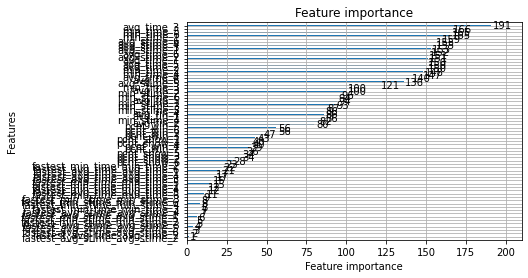

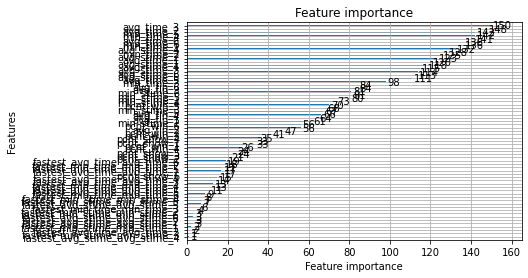

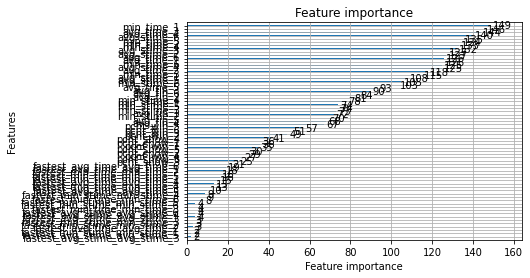

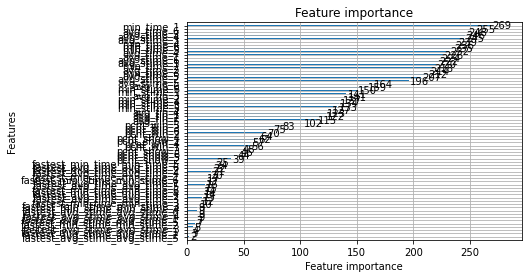

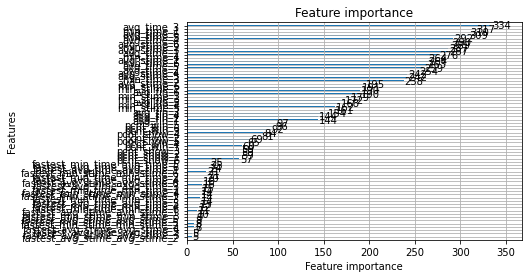

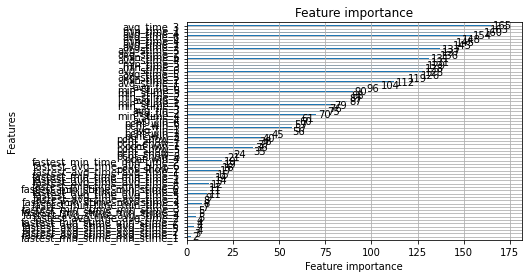

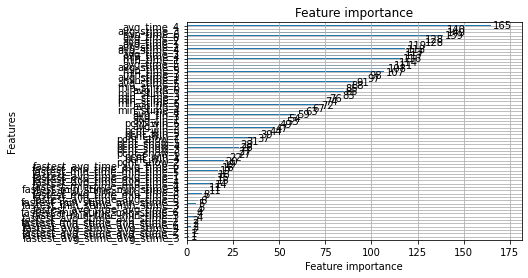

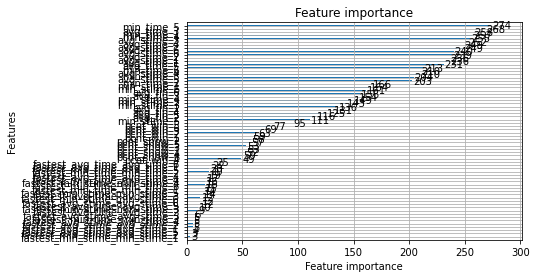

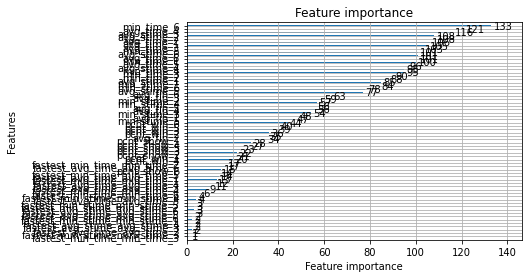

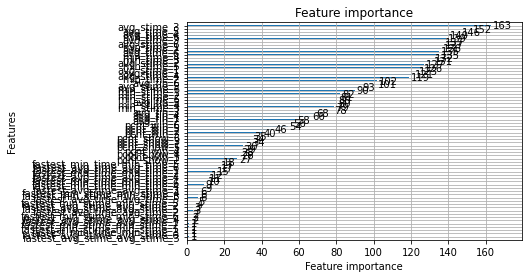

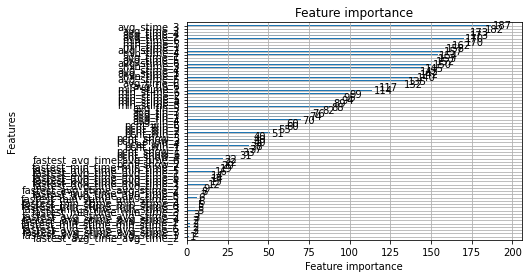

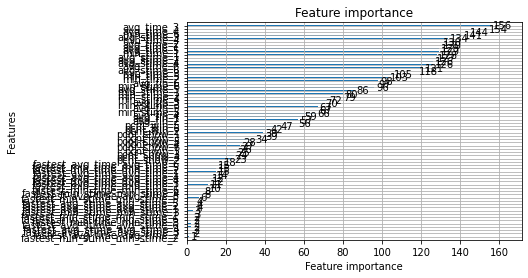

In [39]:
drop_cols = list(modelling_data.filter(regex = 'pcnt_place'))
drop_cols

results['dummies'] = modelling(modelling_data.drop(drop_cols, axis = 1),
                               method = 'cv', nfold = 3, training_months = 150, feature_importance = True)

In [40]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Model Accuracy', 'Benchmark', 'Races', 'Features', 'Training Time'])
results_df.drop('Features', axis = 1)

,Model Accuracy,Benchmark,Races,Training Time
cv,0.195242,0.274169,2648,45.347853
pcnt_place,0.195997,0.274169,2648,40.382834
pcnt_show,0.188066,0.274169,2648,35.404984
pcnt_win,0.173716,0.274169,2648,30.567947
dummies,0.190710,0.274169,2648,45.549094


Unfortunately the dummy variables did not improve the model relative to baseline